In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import tensorflow_hub as hub
import os
import random
import shutil
from math import ceil, sqrt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the directory paths
train_dir = '/content/drive/MyDrive/FYP/Datasets/train'
val_dir = '/content/drive/MyDrive/FYP/Datasets/valid'
test_dir = '/content/drive/MyDrive/FYP/Datasets/test'

# Function to identify classes in a directory
def get_classes(directory):
    return [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

# Get the classes
classes = get_classes(train_dir)

#print(f"Detected classes: {classes}")

In [ ]:


# Create train set
training_images= []
for cls in classes:
    cls_dir = os.path.join(train_dir, cls)
    training_images.extend([os.path.join(cls_dir, img) for img in os.listdir(cls_dir)])


# Create validation set
validation_images = []
for cls in classes:
    cls_dir = os.path.join(val_dir, cls)
    validation_images.extend([os.path.join(cls_dir, img) for img in os.listdir(cls_dir)])



# Create test set
test_images = []
for cls in classes:
    cls_dir = os.path.join(test_dir, cls)
    test_images.extend([os.path.join(cls_dir, img) for img in os.listdir(cls_dir)])





In [ ]:
# Ensure no overlap between datasets
training_set = set(training_images)
validation_set = set(validation_images)
test_set = set(test_images)

# Check for overlaps
assert len(training_set & validation_set) == 0, "Overlap between training and validation sets!"
assert len(training_set & test_set) == 0, "Overlap between training and test sets!"
assert len(validation_set & test_set) == 0, "Overlap between validation and test sets!"

# Check for overlaps and print messages
if len(training_set & validation_set) > 0:
    print("Overlap found between training and validation sets!")
else:
    print("No overlap between training and validation sets.")

if len(training_set & test_set) > 0:
    print("Overlap found between training and test sets!")
else:
    print("No overlap between training and test sets.")

if len(validation_set & test_set) > 0:
    print("Overlap found between validation and test sets!")
else:
    print("No overlap between validation and test sets.")

No overlap between training and validation sets.
No overlap between training and test sets.
No overlap between validation and test sets.


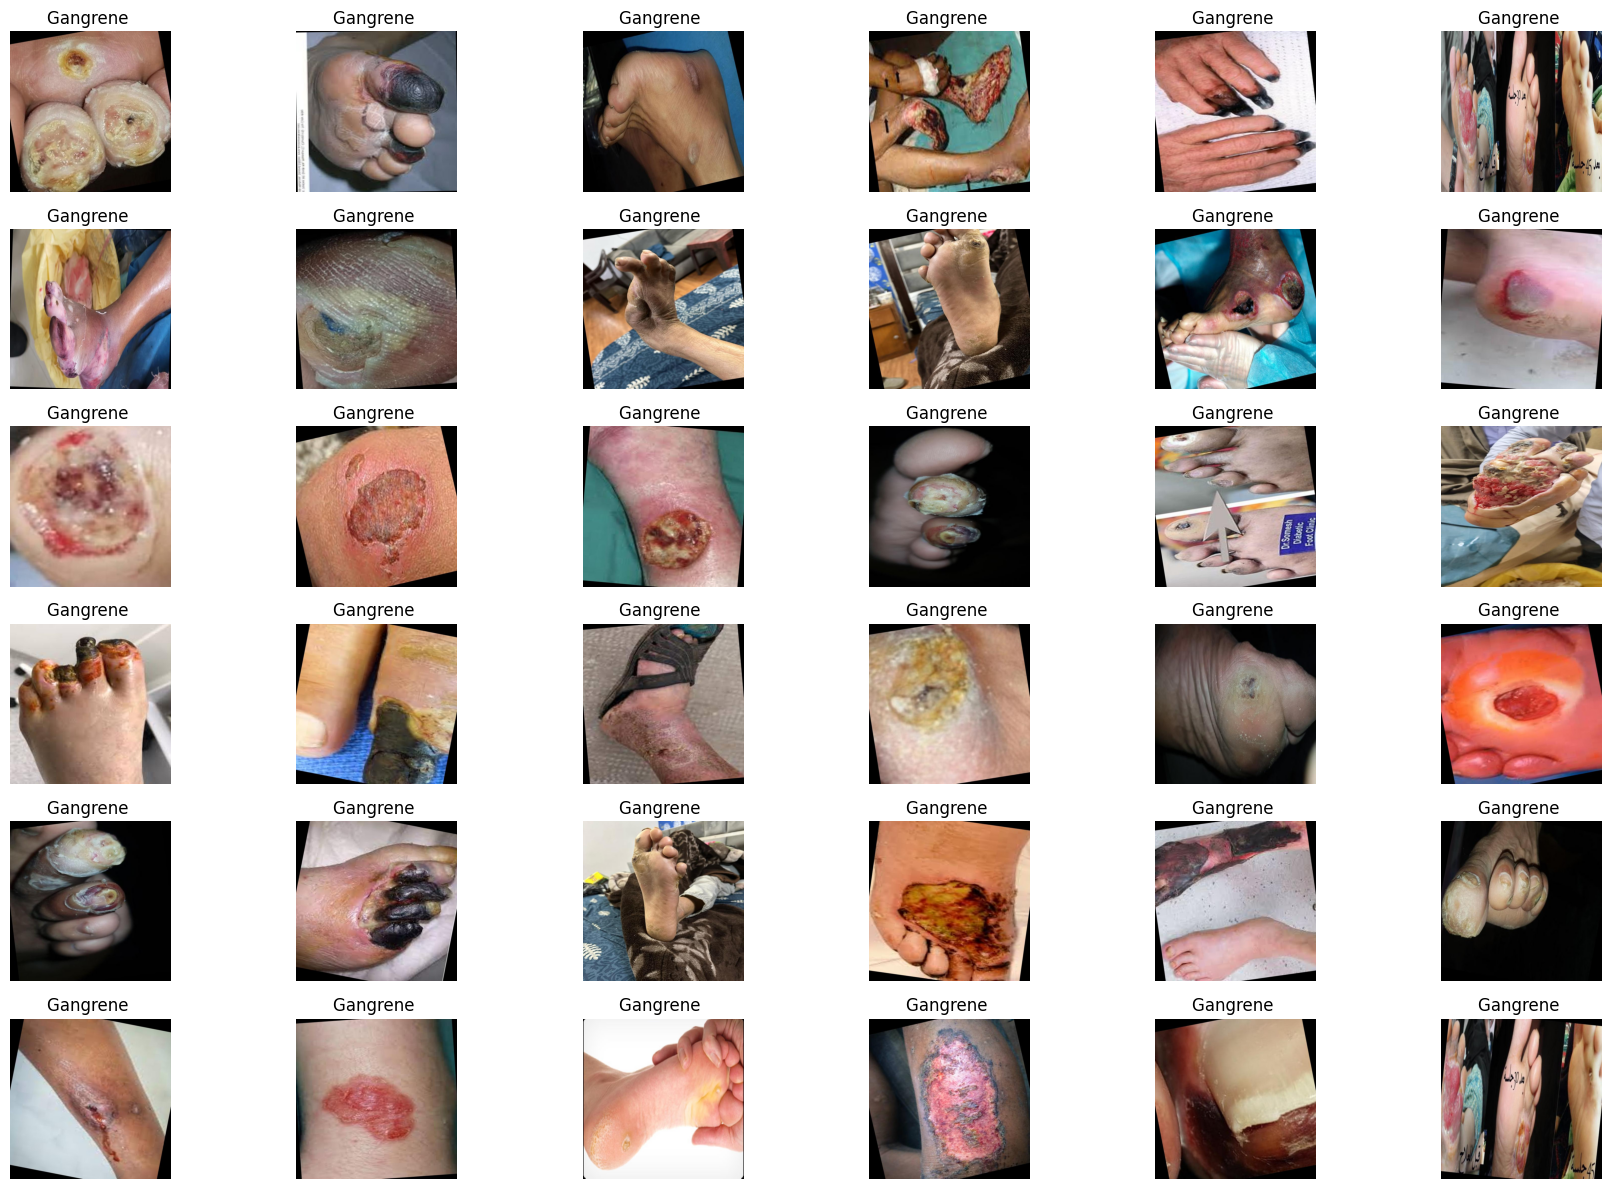

Found 1115 images belonging to 2 classes.
Found 790 images belonging to 2 classes.
Found 708 images belonging to 2 classes.


In [ ]:
# Define the image file paths
images = training_images

# Define the corresponding categories for each image
categories = [img.split(os.sep)[-2] for img in images]

plt.figure(figsize=(18, 12))
for i in range(min(36, len(images))):
    img = plt.imread(images[i])
    plt.subplot(6, 6, i + 1)
    plt.imshow(img)
    plt.title(categories[i])  # Display the category in the title
    plt.axis("off")
plt.tight_layout()
plt.show()

# Create data generators
batch_size = 56
image_size = (224, 224)
#image_size = (300, 300)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,

)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes,

)

validation_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes,

)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    class_mode='categorical',
    classes=classes
)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
#from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax

# Define the number of classes
num_classes = len(classes)


# Build the EfficientNetB0 model
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
#base_model = EfficientNetB3(include_top=False, input_shape=(300, 300, 3), weights='imagenet')

#base_model.trainable = False  # Freeze the base model

# Create a new model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),# Regularization to prevent overfitting
    Dense(256, activation='relu'), # Another added dense layer
    layers.Dropout(0.3), # Regularization to prevent overfitting


    layers.Dense(num_classes, activation='softmax')  # Final layer for classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])





# CutMix with dynamic alpha

def get_cutmix_bbox(width, height, lam):
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = int(width * cut_rat)
    cut_h = int(height * cut_rat)

    cx = np.random.randint(width)
    cy = np.random.randint(height)

    bbx1 = np.clip(cx - cut_w // 2, 0, width)
    bby1 = np.clip(cy - cut_h // 2, 0, height)
    bbx2 = np.clip(cx + cut_w // 2, 0, width)
    bby2 = np.clip(cy + cut_h // 2, 0, height)

    return bbx1, bby1, bbx2, bby2

def cutmix(image_batch, label_batch, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = image_batch.shape[0]
    indices = tf.random.shuffle(tf.range(batch_size))

    shuffled_images = tf.gather(image_batch, indices)
    shuffled_labels = tf.gather(label_batch, indices)

    bbx1, bby1, bbx2, bby2 = get_cutmix_bbox(image_batch.shape[1], image_batch.shape[2], lam)
    new_images = np.copy(image_batch)
    new_images[:, bbx1:bbx2, bby1:bby2, :] = shuffled_images[:, bbx1:bbx2, bby1:bby2, :]

    lam_adjusted = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[1] * image_batch.shape[2]))
    new_labels = lam_adjusted * label_batch + (1 - lam_adjusted) * shuffled_labels
    return new_images, new_labels


# Mosaic with random cut positions

def mosaic(image_batch, label_batch):
    batch_size, img_height, img_width, _ = image_batch.shape
    indices = tf.random.shuffle(tf.range(batch_size))
    shuffled_images = tf.gather(image_batch, indices)
    shuffled_labels = tf.gather(label_batch, indices)

    new_images = np.zeros_like(image_batch)
    new_labels = np.zeros_like(label_batch)

    for i in range(batch_size):
        cut_x = np.random.randint(img_width // 3, (2 * img_width) // 3)
        cut_y = np.random.randint(img_height // 3, (2 * img_height) // 3)

        img1 = image_batch[i]
        img2 = shuffled_images[i]
        lbl1 = label_batch[i]
        lbl2 = shuffled_labels[i]
        img3 = image_batch[indices[i]]
        lbl3 = label_batch[indices[i]]
        img4 = shuffled_images[indices[i]]
        lbl4 = shuffled_labels[indices[i]]

        new_images[i, :cut_y, :cut_x, :] = img1[:cut_y, :cut_x, :]
        new_images[i, :cut_y, cut_x:, :] = img2[:cut_y, cut_x:, :]
        new_images[i, cut_y:, :cut_x, :] = img3[cut_y:, :cut_x, :]
        new_images[i, cut_y:, cut_x:, :] = img4[cut_y:, cut_x:, :]

        new_labels[i] = 0.25 * lbl1 + 0.25 * lbl2 + 0.25 * lbl3 + 0.25 * lbl4

    return new_images, new_labels


# AugMix with noise, blur, and color jitter

def add_noise(img, severity):
    noise = np.random.normal(0, severity, img.shape)
    return np.clip(img + noise, 0, 255).astype(np.uint8)

def blur(img, severity):
    ksize = 3 if severity < 2 else 5
    return cv2.GaussianBlur(img, (ksize, ksize), severity)

def color_jitter(img, severity):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv = hsv.astype(np.float32)
    hsv[..., 1] *= np.random.uniform(0.8, 1.2)
    hsv[..., 2] *= np.random.uniform(0.8, 1.2)
    hsv = np.clip(hsv, 0, 255).astype(np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

augmentations = [add_noise, blur, color_jitter]

def augmix(image, severity=2, width=3, depth=-1, alpha=1.0):
    def augment_and_mix(img):
        ws = np.random.dirichlet([alpha] * width)
        m = np.random.beta(alpha, alpha)
        mix = np.zeros_like(img, dtype=np.float32)
        for i in range(width):
            img_aug = img.copy()
            d = depth if depth > 0 else np.random.randint(1, 4)
            for _ in range(d):
                op = np.random.choice(augmentations)
                img_aug = op(img_aug, severity)
            mix += ws[i] * img_aug
        return ((1 - m) * img + m * mix).astype(np.uint8)

    return augment_and_mix(image)

# ----------------------------------------
# Custom Data Generator
# ----------------------------------------
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator, alpha=1.0):
        self.generator = generator
        self.alpha = alpha

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, idx):
        images, labels = self.generator[idx]

        # Apply CutMix
        images, labels = cutmix(images, labels, alpha=self.alpha)

        # Apply Mosaic
        images, labels = mosaic(images, labels)

        # Apply AugMix
        images = np.array([augmix(image) for image in images])

        return images, labels

#train_generator = CustomDataGenerator(train_generator,alpha=1.0, cutmix_prob=0.5, augmix_prob=0.3)

# Update the train generator(All three augs)
train_generator = CustomDataGenerator(train_generator, alpha=1.0)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/18
20/20 ━━━━━━━━━━━━━━━━━━━━ 818s 38s/step - accuracy: 0.4973 - loss: 1.1438 - val_accuracy: 0.7975 - val_loss: 1.0327 - learning_rate: 0.0010
Epoch 2/18
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.5264 - loss: 1.0686 - val_accuracy: 0.7975 - val_loss: 0.9863 - learning_rate: 0.0010
Epoch 3/18
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.4598 - loss: 1.0168 - val_accuracy: 0.7975 - val_loss: 0.9636 - learning_rate: 0.0010
Epoch 4/18
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.5061 - loss: 0.9614 - val_accuracy: 0.2025 - val_loss: 0.9447 - learning_rate: 0.0010
Epoch 5/18
20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.5139 - loss: 0.9163 - val_accuracy: 0.2025 - val_loss: 0.9135 - learning_rate: 0.0010
Epoch 6/18
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.4984 - loss: 0.8789 - val_accuracy: 0.2025 - val_loss: 0.8582 - learning_rate: 0.0010
Epoch 7/18
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.5163 - loss: 0.8445 - val_accuracy

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


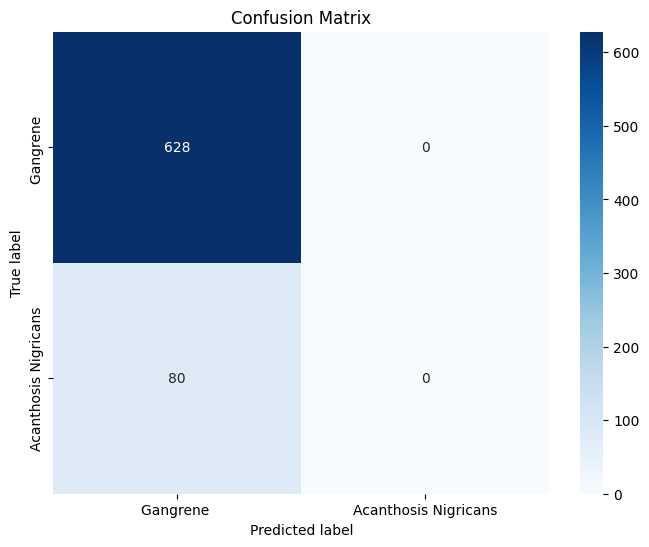

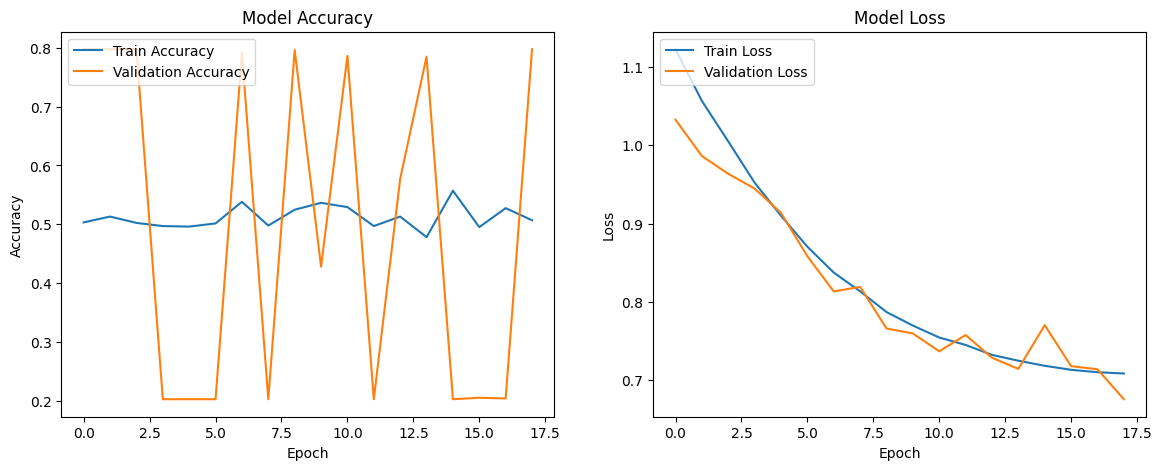

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2



# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=14,  # Set the number of epochs as needed
    batch_size=47,
    callbacks=[early_stopping, checkpoint,reduce_lr]
)

# Save the trained model after training is complete
#model.save('/content/drive/MyDrive/SavedModels/my_model.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Make predictions on the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)  # Convert predictions to class labels
y_true = test_generator.classes  # Get the true labels

# Generate a classification report
target_names = test_generator.class_indices.keys()  # Get the class names
print(classification_report(y_true, y_pred, target_names=target_names))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plot training & validation accuracy and loss
plt.figure(figsize=(14, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()